In [ ]:
## 
! cat ConsensusPeaks.bed ../T2/ConsensusPeaks.bed | sort -k1,1 -k2,2n | bedtools merge -i - > /Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/combined_peaks.bed
! bedtools multicov -bams NC.input.bam NC.m6A.bam T2.input.bam T2.m6A.bam -bed peak_quan/totalReads/forT2/combined_peaks.bed > peak_quan/totalReads/forT2/NC_vs_T2.count

In [30]:
os.chdir("/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/")
df = pd.read_table("NC_vs_T2.count")

# ### bam stat
count_file = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/bam.count"
df_c = pd.read_table(count_file, header=None)
count_dict = dict(zip(df_c.iloc[:,0], df_c.iloc[:,1]))
print(count_dict)
###
sample_cols = df.columns[3:].tolist()
df['peak_len'] = df['end'] - df['start']
for sample in sample_cols:
    df['%s_rpkm'%sample] = (df[sample] * 1000000000) / (df['peak_len'] * count_dict[sample])
df['peak'] = df['#chro'] + ":" + df['start'].astype(str) + "-" + df['end'].astype(str)
sample_list = list(set([x.split("_")[0] for x in sample_cols]))
for case in sample_list:
    df['%s_m6ALevel'%case] = (df['%s_m6A_rpkm'%case]+1) / (df['%s_input_rpkm'%case]+1)
### txt format
df_final = df[['peak'] + ["%s_m6ALevel" % x for x in sample_list]]
print(df_final.head())
df_final.to_csv("FPKM_matrix.txt", sep="\t", index=False)
### bed format
df_final = df[['#chro', 'start', 'end'] + ["%s_m6ALevel" % x for x in sample_list]]
df_final.to_csv("FPKM_matrix.bed", sep="\t", index=False)

{'NC_input': 37861441, 'NC_m6A': 69716419, 'T1_input': 21744437, 'T1_m6A': 50220310, 'T2_input': 13177239, 'T2_m6A': 42963644, 'T3_input': 22897343, 'T3_m6A': 37515691}
                 peak  NC_m6ALevel  T2_m6ALevel
0    chr1:14411-14829     3.264548     3.768137
1  chr1:788736-790120     6.750691     7.135440
2  chr1:791585-792881     5.708069     6.771659
3  chr1:852791-853161     4.438254     6.139791
4  chr1:879077-879758     4.733415     4.936039


In [33]:
os.chdir("/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/")
os.system("mkdir -p targets")
os.system("mkdir -p non-targets")
###### pick out m6A peak
in_file = "FPKM_matrix.bed"
m6a_peak = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/peak_calling/merged_peak_MSPC/NC/ConsensusPeaks.bed"
###
m6a_bed = "overlapM6A.bed"
os.system("bedtools intersect -a %s -b %s -wa | sort -u > %s" % (in_file, m6a_peak, m6a_bed))
### 手工加header [#chro   start   end     NC_m6ALevel     T1_m6ALevel     T2_m6ALevel     T3_m6ALevel]
### split into targets and non-targets
### process biological repeats
df = pd.read_table(m6a_bed, header=None) # , header=None
df.columns = ['#chro','start', 'end', 'NC_m6ALevel','T2_m6ALevel']
kd_samples = df.columns[4:].tolist()
#####
def split_group(sample_name):
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_brain_hg19.bed"
#     fus = "/home/galaxy/project/alleleSpecific_analysis/data/RBP/ENCODE/eCLIP/FUS/combine//union_hg19.bed"
#     fus = "/Charles/project/ASm6A/data/RBP/union/union.bed"
#     fus = "/Charles/project/ASm6A/data/RBP/union/ContainingFUS_genes.bed"
    fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_HEK293T_hg19.bed"
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_brain_hg19.bed"
    #### combine all FUS sets + Gene + Promoter
    fus_target_genes  = "/Charles/project/ASm6A/data/RBP/union/ContainingFUS_genes_promoter.bed"
#     fus_target_genes = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/tmp/FUS_brain_GenePromoter_hg19.bed"
#     fus_target_genes = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/tmp/FUS_brain_Gene"
    ####
    df_sub = df[['#chro', 'start', 'end', "NC_m6ALevel", sample_name]]
    bed = "%s.bed"%sample_name
    df_sub.to_csv(bed, sep="\t", index=False)
    res = "targets/%s" % os.path.basename(bed)
    os.system("bedtools intersect -a %s -b %s -wa | sort -u > %s" % (bed, fus, res))
    res = "non-targets/%s" % os.path.basename(bed)
    os.system("bedtools intersect -a %s -b %s -v -wa | sort -u > %s" % (bed, fus_target_genes, res))
    os.remove(bed)
    
for kd in kd_samples:
    print(kd)
    split_group(kd)

T2_m6ALevel


2177 2177
773 773


/home/galaxy/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


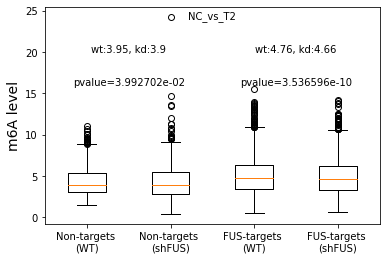

In [35]:
# boxplot 
#### another form of plot
import random
from scipy import stats
import matplotlib.pyplot as plt

target_dir = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/targets/"
non_dir = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/non-targets/"

def get_fc_list(in_file):
    df = pd.read_table(in_file, header=None)
    df = df.dropna()
    wt_list = df.iloc[:,3].tolist()
    wt_list = [x for x in wt_list if x != "nan"]
    kd_list = df.iloc[:,4].tolist()
    kd_list = [x for x in kd_list if x != "nan"]
#     fc_list = [np.log2(x+1) for x in fc_list]
    return wt_list, kd_list
    
# for target_file in target_list:
#     non_file = os.path.join(non_dir, os.path.basename(target_file))
#     #
#     n_wt_list, n_kd_list = get_fc_list(non_file)
#     stat, pvalue = stats.mannwhitneyu(n_wt_list, n_kd_list)
#     a1,b1,c1,d1 = round(np.mean(n_wt_list),2), round(np.mean(n_kd_list),2), round(stat,2), round(pvalue,4)
#     #
#     t_wt_list, t_kd_list = get_fc_list(target_file)
#     stat, pvalue = stats.mannwhitneyu(t_wt_list, t_kd_list)
#     a2,b2,c2,d2 = round(np.mean(t_wt_list),2), round(np.mean(t_kd_list),2), round(stat,2), round(pvalue,4)
#     print(os.path.basename(target_file), a1,b1,d1, a2,b2,d2)
sample = "T2_m6ALevel.bed"
target_file = os.path.join(target_dir, sample)
non_file = os.path.join(non_dir, sample)
##
t_wt_list, t_kd_list = get_fc_list(target_file)
t_median = "wt:%s, kd:%s" % (str(round(np.median(t_wt_list),2)), str(round(np.median(t_kd_list),2)))
t_stat, t_pvalue = stats.ttest_rel(t_wt_list, t_kd_list)
print(len(t_wt_list), len(t_kd_list))
##
n_wt_list, n_kd_list = get_fc_list(non_file)
# random_index_list = random.sample(list(range(len(n_wt_list))), len(t_wt_list))
# n_wt_list, n_kd_list = [n_wt_list[i] for i in random_index_list], [n_kd_list[i] for i in random_index_list]
n_median = "wt:%s, kd:%s" % (str(round(np.median(n_wt_list),2)), str(round(np.median(n_kd_list),2)))
n_stat, n_pvalue = stats.ttest_rel(n_wt_list, n_kd_list)
print(len(n_wt_list), len(n_kd_list))
####
x = [n_wt_list,n_kd_list,t_wt_list,t_kd_list]
plt.boxplot(x, labels=["Non-targets \n(WT)","Non-targets \n(shFUS)","FUS-targets \n(WT)","FUS-targets \n(shFUS)"])
plt.ylabel('m6A level', size = 14)
plt.xticks(rotation=0)
plt.text(1.5, 16, 'pvalue=%e'%n_pvalue, horizontalalignment='center')
plt.text(1.5, 20, n_median, horizontalalignment='center')
plt.text(3.5, 16, 'pvalue=%e'%t_pvalue, horizontalalignment='center')
plt.text(3.5, 20, t_median, horizontalalignment='center')
plt.text(2.5, 24, "NC_vs_%s"%sample.split("_")[0], horizontalalignment='center')
plt.show()

T2_m6ALevel.bed -0.04264049869194737 -0.09988493992029993 2177 773 6.205843727791205e-09


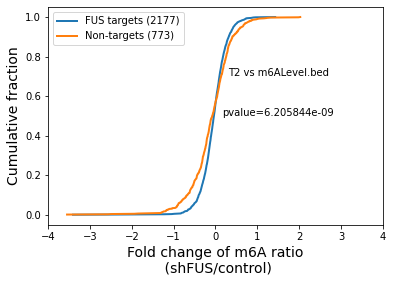

In [38]:
#### compare (kd-test)
import random
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

target_dir = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/targets/"
non_dir = "/Charles/mjy/210505_A00869_0471_BH3NHMDSX2/mapping/human/bam/peak_quan/totalReads/forT2/non-targets/"
# target_list = glob.glob("%s/*.bed" % target_dir)

def get_fc_list(in_file):
    df = pd.read_table(in_file, header=None)
    df = df.dropna()
    df['fc'] = df.iloc[:,4] / df.iloc[:,3]
    fc_list = df['fc'].tolist()
    fc_list = [x for x in fc_list if x != "nan"]
    fc_list = [np.log2(x) for x in fc_list]
    return fc_list


target_file = os.path.join(target_dir, "T2_m6ALevel.bed")
non_file = os.path.join(non_dir, "T2_m6ALevel.bed")
t_list, n_list = get_fc_list(target_file), get_fc_list(non_file)
####
# n_list = random.sample(n_list, len(t_list))
(ks_stat, pval) = stats.ks_2samp(t_list, n_list)
print(os.path.basename(target_file), np.mean(t_list), np.mean(n_list), len(t_list), len(n_list), pval)

x_asm6a, y_asm6a = dcst.ecdf(t_list)
x, y = dcst.ecdf(n_list)
_ = plt.plot(x_asm6a, y_asm6a, lw = 2)
_ = plt.plot(x, y, lw = 2) # linestyle='--', 
_ = plt.legend(("FUS targets (%d)"% len(t_list), "Non-targets (%d)" % len(n_list)))
_ = plt.xlabel('Fold change of m6A ratio\n (shFUS/control)', size = 14) # Log2 
_ = plt.ylabel('Cumulative fraction', size = 14)
_ = plt.text(1.5, 0.5, 'pvalue=%e'%pval, horizontalalignment='center')
sample = os.path.basename(target_file).split("_m6A.txt")[0].replace("_", " vs ")
_ = plt.text(1.5, 0.7, sample, horizontalalignment='center')
_ = plt.xlim((-4,4))
plt.show()